In [2]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce
from xgboost import XGBRegressor



In [5]:
#Load your dataset
df = pd.read_csv("IMDb_Movies_India.csv",encoding="latin-1")  # Adjust filename if needed

#Drop rows with missing target
df = df.dropna(subset=["Rating"])

#Fill missing values in categorical columns
df['Genre'] = df['Genre'].fillna('Unknown')
df['Director'] = df['Director'].fillna('Unknown')
df['Actor 1'] = df['Actor 1'].fillna('Unknown')

#Select useful features (add more if available in your dataset)
features = ["Genre", "Director", "Actor 1", "No_of_Votes", "Duration", "Year"]

# Check which of the desired features actually exist
desired_features = ["Genre", "Director", "Actor 1", "No_of_Votes", "Duration", "Year"]
available_features = [col for col in desired_features if col in df.columns]

X = df[available_features]
y = df["Rating"]

In [6]:
#Fill missing values in numeric columns
for col in ["No_of_Votes", "Duration", "Year"]:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
        X[col] = X[col].fillna(X[col].median())

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Build pipeline with TargetEncoder + XGBoost
encoder = ce.TargetEncoder(cols=["Genre", "Director", "Actor 1"])
model = make_pipeline(
    encoder,
    XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        n_jobs=-1,
        random_state=42
    )
)

#Train the model
model.fit(X_train, y_train)

/tmp/ipython-input-6-3963608474.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')
/tmp/ipython-input-6-3963608474.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].median())


Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Genre', 'Director', 'Actor 1'])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import category_encoders as ce
from sklearn.pipeline import Pipeline
#Define the parameter grid
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}
#Create a pipeline with encoder + model
pipeline = Pipeline([
    ('encoder', ce.TargetEncoder(cols=["Genre", "Director", "Actor 1"])),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])
#Run RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('encoder',
                                              TargetEncoder(cols=['Genre',
                                                                  'Director',
                                                                  'Actor 1'])),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=N...
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.6, 0.8,
                                                                  1.0],
                                        'xgb__learning_rate': [0.01, 0.05, 0.1,
                                                               0.2],
                                        'xgb__max_depth': [3, 5, 7, 10],
                                        'xgb__n_estimators': [100, 200, 300],
                                        'xgb__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [9]:
#Evaluate the best model
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Best Parameters:", search.best_params_)
print("✅ Tuned RMSE:", rmse)
print("✅ Tuned R² Score:", r2)

✅ Best Parameters: {'xgb__subsample': 0.6, 'xgb__n_estimators': 200, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.6}
✅ Tuned RMSE: 1.4590596388582329
✅ Tuned R² Score: 0.21519863782449522


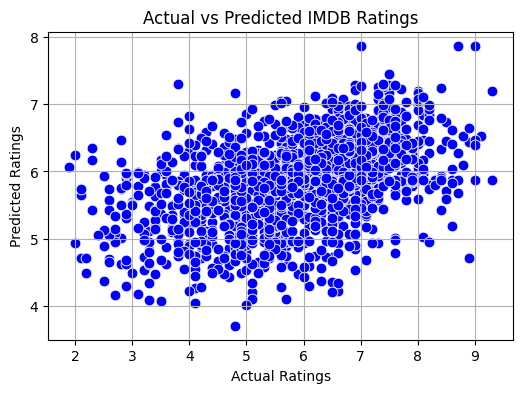

In [14]:
#Plot Actual vs Predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color='blue', edgecolor='white', s=60)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted IMDB Ratings")
plt.grid(True)
plt.show()

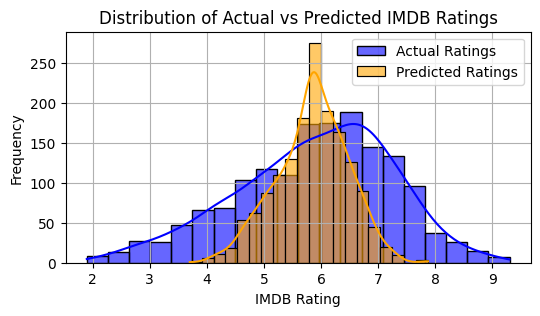

In [13]:
#Histogram of Actual vs Predicted
plt.figure(figsize=(6, 3))
sns.histplot(y_test, color='blue', label='Actual Ratings', kde=True, bins=20, alpha=0.6)
sns.histplot(y_pred, color='orange', label='Predicted Ratings', kde=True, bins=20, alpha=0.6)
plt.xlabel("IMDB Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Actual vs Predicted IMDB Ratings")
plt.legend()
plt.grid(True)
plt.show()